In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
from skimage import transform
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.multiprocessing as mp
import monai
from segment_anything import sam_model_registry
import torch.nn.functional as F
import argparse
import random
from datetime import datetime
import shutil
import glob
import pandas as pd
import nibabel as nib
import pickle
import time

from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.MedSAM import MedSAM
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.loss_funcs_hcp import *

In [2]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/MedSAM/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
label_converter = LabelConverter(df_hcp, df_desired)

model = build_sam_vit_b_multiclass(num_classes=NUM_CLASSES, checkpoint='/gpfs/home/kn2347/results/models_8-9-23/scratch_loss_reweighted_lr1e-4_ce_only_longer3_model_20230804-133537/model_best.pth')
medsam_model = MedSAM(image_encoder=model.image_encoder, 
                        mask_decoder=model.mask_decoder,
                        prompt_encoder=model.prompt_encoder
                        ).cuda()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [26]:
num_nodes = 6
this_node_rank = 0
fracs = np.linspace(0, 1, num_nodes+1)

# load dataframe of slice paths
path_df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv')

# load train val test ids
dicto = pickle.load(open('/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle', 'rb'))
train_ids = dicto['train']
val_ids = dicto['val']
test_ids = dicto['test']
total_ids = train_ids + val_ids + test_ids

cutpoints = [round(x * len(total_ids)) for x in fracs]
assert cutpoints[-1] == len(total_ids)
total_ids = total_ids[cutpoints[this_node_rank] : cutpoints[this_node_rank+1]]

total_df = path_df[path_df['id'].isin(total_ids)].reset_index(drop=True)

total_dataset = MRIDataset(total_df, None, 0, label_converter = label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=True)


In [27]:
def proc_arr(arr):
    # arr has shape (B, classes, *)
    ax_starts = np.argmax(arr, axis=2) # shape (B, classes)
    ax_ends = arr.shape[2] - 1 - np.argmax(arr[:,:,::-1], axis=2) # shape (B, classes)

    maxs = np.max(arr, axis = 2) # shape (B, classes)
    ax_starts = np.where(maxs == 1, ax_starts, np.nan)
    ax_ends = np.where(maxs == 1, ax_ends, np.nan)

    return ax_starts, ax_ends


def get_bounding_box(seg_arr):
    # seg_tens has shape (B, C,256,256)
    # return shape (4, classes) - rmin, rmax, cmin, cmax
    
    cols = np.any(seg_arr, axis=2) # (B, classes, W)
    rows = np.any(seg_arr, axis=3) # (B, classes, H) of True/False, now find min row and max row with True
    
    rmin, rmax = proc_arr(rows)
    cmin, cmax = proc_arr(cols)

    return np.stack([cmin, cmax, rmin, rmax], axis = 2) # (B, C, 4)

In [28]:
dataloader = DataLoader(
        total_dataset,
        batch_size = 64,
        shuffle = False,
        num_workers = 0,
        pin_memory = True
)
rt_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/saved_round1_segmentations_bbox'

for step, (image_embedding, gt2D, boxes, slice_names) in enumerate(tqdm(dataloader)):
    image_embedding, gt2D, boxes = image_embedding.cuda(), gt2D.cuda(), boxes.cuda()
    out = medsam_inference(medsam_model, image_embedding, boxes, 256, 256, True, True).astype(bool)
    # out has shape (B, C, H, W)

    bboxes = get_bounding_box(out) # (B, C, 4)
    id_names = [x.split('_')[0] for x in slice_names]
    
    for i in range(len(slice_names)):
        id_name = slice_names[i].split('_')[0]
        if not os.path.exists(os.path.join(rt_path, id_name)):
            os.makedirs(os.path.join(rt_path, id_name))
        suffix = slice_names[i].split('slice')[-1] # should be something like "0.npy"

        full_path_this = os.path.join(rt_path, id_name, suffix)
        np.save(full_path_this, bboxes)
        
        

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:25<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 15.78 GiB total capacity; 13.69 GiB already allocated; 128.00 MiB free; 14.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:



res = medsam_inference(medsam_model, train_dataset[0], train_dataset[2], 256, 256, as_one_hot=True, model_trained_on_multi_label=True)
# res is B, C, H, W

In [ ]:
dataloader = DataLoader(
    test_ds,
    batch_size = 16,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

In [32]:
arr.shape

(32, 103, 4)

In [37]:
np.isnan(arr).any(axis=2).shape

(32, 103)

[ 44. 209. 127. 194.]


In [23]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/MedSAM/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
label_converter = LabelConverter(df_hcp, df_desired)

path_df_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv'
train_test_splits_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle'
train_dataset, val_dataset, test_dataset = load_datasets(path_df_path, train_test_splits_path, label_id = None, bbox_shift=0, label_converter=label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=False)


model = build_sam_vit_b_multiclass(num_classes=NUM_CLASSES, checkpoint='/gpfs/home/kn2347/results/models_8-9-23/scratch_loss_reweighted_lr1e-4_ce_only_longer3_model_20230804-133537/model_best.pth')
medsam_model = MedSAM(image_encoder=model.image_encoder, 
                        mask_decoder=model.mask_decoder,
                        prompt_encoder=model.prompt_encoder,
                        multimask_output=True
                        ).cuda()

In [31]:
output[0,:,:].sum()

0

152.0 152.0 172.0 172.0


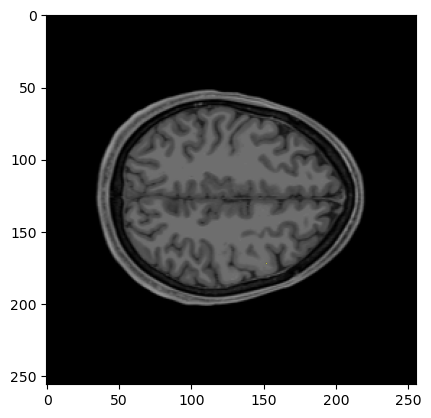

In [39]:
idx = 108
label = 0
B = 1
embed, gt, boxes, slice_name = val_dataset[idx]
embed, gt, boxes= embed.cuda(), gt.cuda(), boxes.cuda()
boxes = boxes.reshape(B, -1)

img = np.repeat(val_dataset.load_image(idx)[:,:,None], 3, axis=-1)
output = medsam_inference(medsam_model, embed, boxes, 256, 256, True, True).astype(bool)[0,:,:,:]
arr = np.load(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/saved_round1_segmentations_bbox/102109/{idx}.npy')

fig, ax = plt.subplots()

ax.imshow(img)


subarr = arr[label, :]

x0, x1 = subarr[0], subarr[1]
y0, y1 = subarr[2], subarr[3]
width = x1-x0
height = y1-y0
ax.add_patch(plt.Rectangle((x0, y0), width, height, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

#show_mask(gt[label,:,:], ax)
show_mask(output[label,:,:], ax)


In [4]:
dfo = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv')


In [ ]:
bbox_paths = '/gpfs/data/luilab/karthik/pediatric_seg_proj/saved_round1_segmentations_bbox/' + dfo.id.map(str) + '/' + dfo.slice.map(str) + '.npy'
label=1
collect_list = [np.load(bbox_paths[i])[:, [0,2,1,3]] for i in tqdm(range(len(bbox_paths)))] # reorders into x_min, y_min, x_max, y_max
collect_list # each elem is shape (class, 4)
# so stacking will give (batch, class, 4)
#bbox_X[np.all(~np.isnan(bbox_X), axis = 1), :].shape


In [21]:
np.load(bbox_paths[0])[1]

array([nan, nan, nan, nan])

In [6]:
dfo = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv')
merged = np.stack(collect_list) # B, C, 4
print(merged.shape)

merged = merged[np.all(~np.isnan(merged), axis=2),:]
for class_num in range(NUM_CLASSES):
    this_class_df = dfo
    for i in range(4):
        this_class_df[f'bbox_{i}'] = merged[:, class_num, i]

    new_df = this_class_df.dropna(how='any', subset = ['bbox_0', 'bbox_1', 'bbox_2', 'bbox_3']).reset_index(drop=True)
    new_df.bbox_0 = new_df.bbox_0.astype(int)
    new_df.bbox_1 = new_df.bbox_1.astype(int)
    new_df.bbox_2 = new_df.bbox_2.astype(int)
    new_df.bbox_3 = new_df.bbox_3.astype(int)
    new_df.to_csv(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/path_df_label{class_num}_only_with_bbox.csv')

(284928, 103, 4)


In [10]:
# now write the exact same df, but with constant bbox
for class_num in range(1,103):
    dfo = pd.read_csv(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/medsam/path_df_label{class_num}_only_with_bbox.csv', index_col=0)
    dfo['bbox_0'] = 0
    dfo['bbox_1'] = 0
    dfo['bbox_2'] = 256
    dfo['bbox_3'] = 256
    dfo.to_csv(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/medsam/constant_bbox/path_df_label{class_num}_constant_bbox.csv', index=False)

In [53]:
pt2_path = '/gpfs/home/kn2347/MedSAM/class_mappings'
orig_df = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')

for class_num in range(1,NUM_CLASSES):
    this_df = orig_df
    this_df = this_df[this_df['region_index'].isin([0, class_num])]
    this_df.loc[ (this_df['region_index'] == class_num), 'region_index'] = 1
    this_df = this_df.reset_index(drop=True)
    this_df.to_csv(f'{pt2_path}/label{class_num}_only_name_class_mapping.csv', index=False)